In [1]:
# Cleaning Dependencies
import pandas as pd
import datetime
import calendar

In [2]:
# Machine Learning Dependencies
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from xgboost.sklearn import XGBRegressor

import statsmodels.api as sm
import seaborn as sns

import tensorflow
import tensorflow.keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM

In [3]:
# We now need to load the cleaned data.
df = pd.read_csv("Retail_Sales_Data/Official_Merged_SF.csv")
df.head()

,sale_date,store,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,unemployment,isholiday,dept,weekly_sales
0,2012-09-28,16,51.40,3.789,2130.57,3.82,NaN,583.90,1409.43,6.061,False,27,836.65
1,2012-10-19,16,40.59,3.750,1278.03,NaN,1.16,16.38,1395.48,5.847,False,27,852.81
2,2012-10-26,16,40.99,3.686,2285.52,20.48,NaN,201.97,1237.41,5.847,False,27,815.95
3,2010-02-19,16,21.13,2.550,NaN,NaN,NaN,NaN,NaN,7.039,False,28,266.00
4,2010-02-26,16,18.12,2.586,NaN,NaN,NaN,NaN,NaN,7.039,False,28,255.50


In [4]:
# We will need a column that records the year and month for our regular linear regression chart.
df['year_month'] = pd.to_datetime(df['sale_date']).dt.to_period('M')
df.head()

,sale_date,store,temperature,fuel_price,markdown1,markdown2,markdown3,markdown4,markdown5,unemployment,isholiday,dept,weekly_sales,year_month
0,2012-09-28,16,51.40,3.789,2130.57,3.82,NaN,583.90,1409.43,6.061,False,27,836.65,2012-09
1,2012-10-19,16,40.59,3.750,1278.03,NaN,1.16,16.38,1395.48,5.847,False,27,852.81,2012-10
2,2012-10-26,16,40.99,3.686,2285.52,20.48,NaN,201.97,1237.41,5.847,False,27,815.95,2012-10
3,2010-02-19,16,21.13,2.550,NaN,NaN,NaN,NaN,NaN,7.039,False,28,266.00,2010-02
4,2010-02-26,16,18.12,2.586,NaN,NaN,NaN,NaN,NaN,7.039,False,28,255.50,2010-02


In [5]:
# We'll use a subset of this dataframe that only focuses on relevant columns.
df_compact = df[["sale_date", "store", "dept", "weekly_sales"]]
df_compact.head()

,sale_date,store,dept,weekly_sales
0,2012-09-28,16,27,836.65
1,2012-10-19,16,27,852.81
2,2012-10-26,16,27,815.95
3,2010-02-19,16,28,266.00
4,2010-02-26,16,28,255.50


In [6]:
# Before proceeding, we want to figure out which stores have the highest and lowest
# average weekly sales.

# Convert the sale date to the datetime format.
df_compact.sale_date = pd.to_datetime(df_compact.sale_date)

# Get the average weekly sales of all stores.
averages = df_compact.groupby('store')['weekly_sales'].mean()

# Change the sorted averages into a dataframe.
df_averages = pd.DataFrame(averages)

df_averages.head()

,weekly_sales
store,
1,21356.269055
2,26632.390198
3,6290.115528
4,29192.292294
5,4996.004881


In [7]:
# We'll sort the stores by average weekly sales to determine which are the most profitable.
df_averages_largest = df_averages.sort_values(by=['weekly_sales'], ascending=False)
df_averages_largest.head()

,weekly_sales
store,
4,29192.292294
20,29041.564511
14,28368.875115
13,27375.601465
2,26632.390198


In [8]:
# Knowing it's stores 4, 20, 14, 13, and 2 that have the highest average weekly sales,
# we will store those store numbers in a list for later filtering.
most_profitable_stores = [4, 20, 13, 14, 2]

In [9]:
# Same process with the least profitable stores.
df_averages_smallest = df_averages.sort_values(by=['weekly_sales'], ascending=True)
df_averages_smallest.head()

,weekly_sales
store,
5,4996.004881
33,5629.787360
44,6062.370884
3,6290.115528
38,7323.140938


In [10]:
least_profitable_stores = [33, 44, 5, 3, 38]

In [11]:
# We can now filter the original dataframe to only include information about the most and least
# profitable stores using the .isin() function.
most_profitable_stores_df = df[df.store.isin(most_profitable_stores)]
most_profitable_stores_df = most_profitable_stores_df[['sale_date', 'weekly_sales']].reset_index(drop=True)
most_profitable_stores_df

,sale_date,weekly_sales
0,2010-02-19,55649.79
1,2010-02-26,36805.42
2,2010-12-03,47291.77
3,2010-03-19,52993.00
4,2010-03-26,61598.76
...,...,...
68731,2012-07-27,0.08
68732,2012-08-17,0.09
68733,2012-08-24,1320.12
68734,2012-08-31,40.08


In [12]:
least_profitable_stores_df = df[df.store.isin(least_profitable_stores)]
least_profitable_stores_df = least_profitable_stores_df[['sale_date', 'weekly_sales']].reset_index(drop=True)
least_profitable_stores_df

,sale_date,weekly_sales
0,2010-02-19,3359.00
1,2010-02-26,1048.70
2,2010-12-03,1288.40
3,2010-03-19,1123.05
4,2010-03-26,1077.68
...,...,...
52425,2012-02-24,1.50
52426,2012-04-20,-5.96
52427,2012-06-29,36.00
52428,2012-07-13,27.00


In [13]:
# We need to organize teh average weekly sales by month. For this, we'll use the following function.
def store_compactor(data):
    to_change = data.copy()
    to_change.sale_date = to_change.sale_date.apply(lambda x: str(x)[:-3])      
    to_change = to_change.groupby(['sale_date', 'store'])['weekly_sales'].mean().reset_index()    
    to_change.date = pd.to_datetime(to_change.sale_date)    
    return to_change

In [14]:
monthly = store_compactor(df)
monthly

,sale_date,store,weekly_sales
0,2010-02,1,20839.281103
1,2010-02,2,27325.676781
2,2010-02,3,6475.367578
3,2010-02,4,27044.823810
4,2010-02,5,4413.301538
...,...,...,...
1480,2012-10,41,18480.698112
1481,2012-10,42,10254.010291
1482,2012-10,43,12237.603838
1483,2012-10,44,6522.227048


In [15]:
# We need subset dataframes for each of the top 5 most profitable stores.
store_2_df = monthly[monthly.store == 2].rename(columns={"weekly_sales": "Store 2", "sale_date": "year & month"})
store_4_df = monthly[monthly.store == 4].rename(columns={"weekly_sales": "Store 4", "sale_date": "year & month"})
store_13_df = monthly[monthly.store == 13].rename(columns={"weekly_sales": "Store 13", "sale_date": "year & month"})
store_14_df = monthly[monthly.store == 14].rename(columns={"weekly_sales": "Store 14", "sale_date": "year & month"})
store_20_df = monthly[monthly.store == 20].rename(columns={"weekly_sales": "Store 20", "sale_date": "year & month"})



In [16]:
# Now for the least profitable stores.
store_3_df = monthly[monthly.store == 3].rename(columns={"weekly_sales": "Store 3", "sale_date": "year & month"})
store_5_df = monthly[monthly.store == 5].rename(columns={"weekly_sales": "Store 5", "sale_date": "year & month"})
store_33_df = monthly[monthly.store == 33].rename(columns={"weekly_sales": "Store 33", "sale_date": "year & month"})
store_38_df = monthly[monthly.store == 38].rename(columns={"weekly_sales": "Store 38", "sale_date": "year & month"})
store_44_df = monthly[monthly.store == 44].rename(columns={"weekly_sales": "Store 44", "sale_date": "year & month"})

In [17]:
# Plotting dependencies.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
tick_spacing = 3

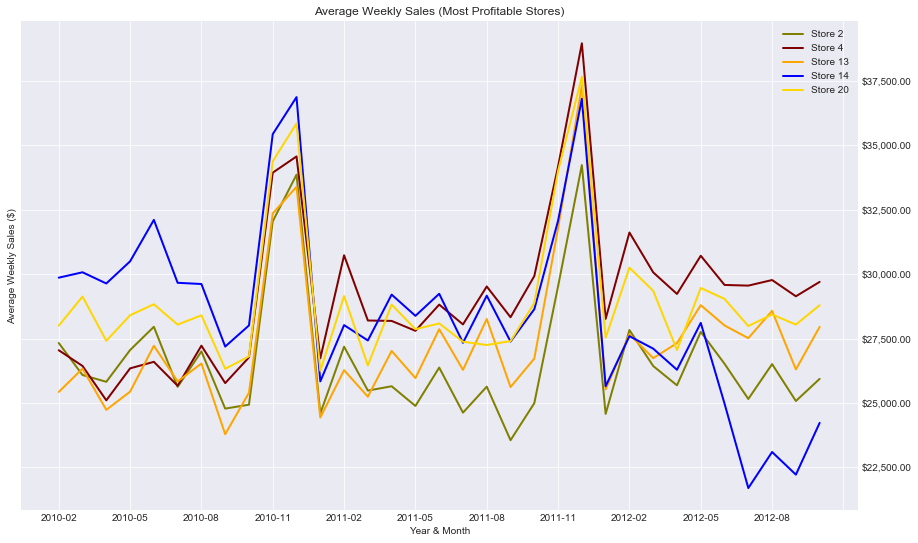

In [55]:
# We will now plot the average weekly sales by month, beginning with most profitable stores.
fig, ax = plt.subplots(figsize=(15,9))
plt.style.use('seaborn-darkgrid')
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax.set_title('Average Weekly Sales (Most Profitable Stores)')
ax.set_ylabel('Average Weekly Sales ($)')
ax.set_xlabel('Year & Month')

dollar_format = '${x:,.2f}'
tick = ticker.StrMethodFormatter(dollar_format)
ax.yaxis.set_major_formatter(tick)

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_visible(False)
    tick.label2.set_visible(True)

plt.plot( 'year & month', 'Store 2', data=store_2_df, marker='', color='olive', linewidth=2)
plt.plot( 'year & month', 'Store 4', data=store_4_df, marker='', color='maroon', linewidth=2)
plt.plot( 'year & month', 'Store 13', data=store_13_df, marker='', color='orange', linewidth=2)
plt.plot( 'year & month', 'Store 14', data=store_14_df, marker='', color='blue', linewidth=2)
plt.plot( 'year & month', 'Store 20', data=store_20_df, marker='', color='gold', linewidth=2)
plt.legend()
plt.savefig("Images/AVG_Weekly_Sales_Most.png")

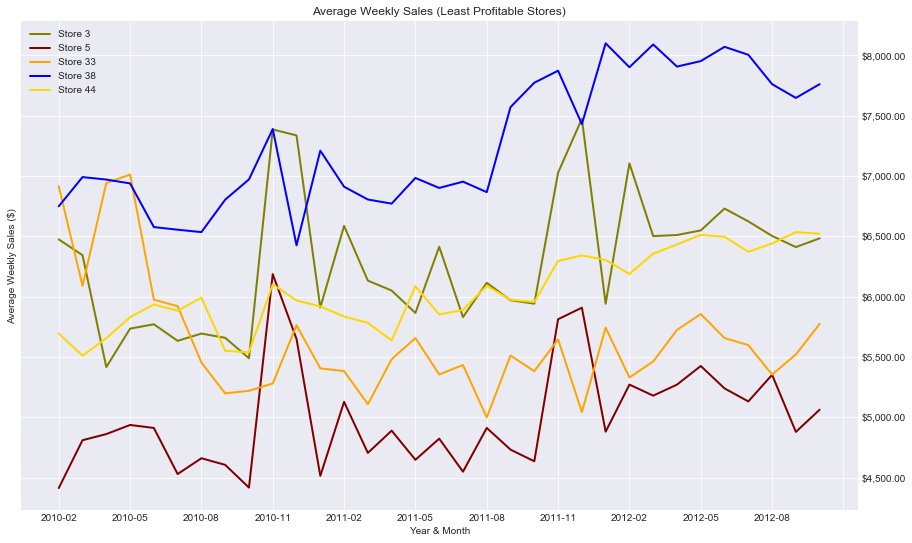

In [19]:
# Now the least profitable stores.
fig2, ax2 = plt.subplots(figsize=(15,9))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
ax2.set_title('Average Weekly Sales (Least Profitable Stores)')
ax2.set_ylabel('Average Weekly Sales ($)')
ax2.set_xlabel('Year & Month')

dollar_format = '${x:,.2f}'
tick = ticker.StrMethodFormatter(dollar_format)
ax2.yaxis.set_major_formatter(tick)

for tick in ax2.yaxis.get_major_ticks():
    tick.label1.set_visible(False)
    tick.label2.set_visible(True)

plt.plot( 'year & month', 'Store 3', data=store_3_df, marker='', color='olive', linewidth=2)
plt.plot( 'year & month', 'Store 5', data=store_5_df, marker='', color='maroon', linewidth=2)
plt.plot( 'year & month', 'Store 33', data=store_33_df, marker='', color='orange', linewidth=2)
plt.plot( 'year & month', 'Store 38', data=store_38_df, marker='', color='blue', linewidth=2)
plt.plot( 'year & month', 'Store 44', data=store_44_df, marker='', color='gold', linewidth=2)
plt.legend()
plt.savefig("Images/AVG_Weekly_Sales_Least.png")

In [20]:
# We will need to create a function that sorts this filtered data into average
# sales by every month in the set. This is separate from the other compactor
# function because we're specifically focusing on the most and least dfs
# are are not focusing on specific stores.

def compactor(to_change):
    data = to_change.copy()
    data.sale_date = data.sale_date.apply(lambda x: str(x)[:-3])      
    data = data.groupby('sale_date')['weekly_sales'].mean().reset_index()    
    data.date = pd.to_datetime(data.sale_date)    
    return data

In [21]:
# We'll use the function for the most profitable stores first.
df_ordered_most = compactor(most_profitable_stores_df)
df_ordered_most.head()

,sale_date,weekly_sales
0,2010-02,27514.575800
1,2010-03,27585.236924
2,2010-04,26516.842882
3,2010-05,27524.318402
4,2010-06,28523.370296


In [22]:
# And now least profitable stores.
df_ordered_least = compactor(least_profitable_stores_df)
df_ordered_least.head()

,sale_date,weekly_sales
0,2010-02,5955.095084
1,2010-03,5908.454566
2,2010-04,5850.818209
3,2010-05,5997.234646
4,2010-06,5786.870205


In [23]:
# We'll need to rename the weekly sales column to reflect what we're finding.
most_profitable = df_ordered_most.rename(columns={"weekly_sales": "average_weekly_sales"})
least_profitable = df_ordered_least.rename(columns={"weekly_sales": "average_weekly_sales"})

In [24]:
# We need to reformat the dates so that they can be treated as datetime values.
most_profitable['date'] = most_profitable['sale_date'] + "-01"
least_profitable['date'] = least_profitable['sale_date'] + "-01"
most_df = most_profitable[['date', 'average_weekly_sales']]
least_df = least_profitable[['date', 'average_weekly_sales']]

In [25]:
# We'll convert to datetime now.
most_df['date'] = pd.to_datetime(most_df['date'], format='%Y-%m-%d')
least_df['date'] = pd.to_datetime(least_df['date'], format='%Y-%m-%d')
most_df.head()

,date,average_weekly_sales
0,2010-02-01,27514.575800
1,2010-03-01,27585.236924
2,2010-04-01,26516.842882
3,2010-05-01,27524.318402
4,2010-06-01,28523.370296


In [26]:
# Okay! Now that our data is marinated, we will set up our time series plots.
# Firstly, a basic chart displaying the average weekly sales.
def time_plot(data, x_col, y_col, title):
    fig, ax = plt.subplots(figsize=(10,4))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')
    
    second = data.groupby(data.date.dt.year)[y_col].mean().reset_index()
    second.date = pd.to_datetime(second.date, format='%Y')
    sns.lineplot((second.date + datetime.timedelta(6*365/12)), y_col, data=second, ax=ax, color='red', label='Mean Sales')   
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = title)
    
    sns.despine()
    plt.savefig(f'Images/{title}.png')

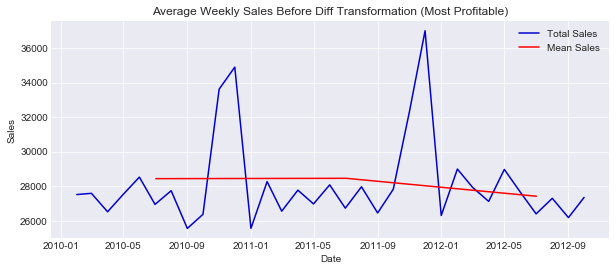

In [27]:
# We will not apply this function to most_df.
time_plot(most_df, 'date', 'average_weekly_sales', 'Average Weekly Sales Before Diff Transformation (Most Profitable)')

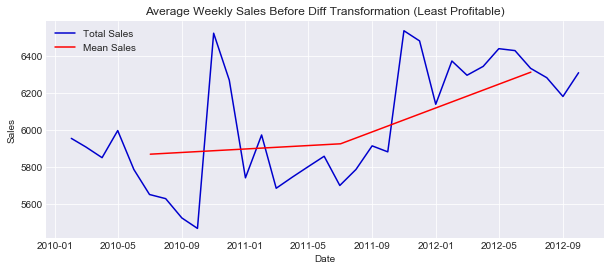

In [28]:
# And least_df.
time_plot(least_df, 'date', 'average_weekly_sales', 'Average Weekly Sales Before Diff Transformation (Least Profitable)')

In [29]:
# Now we must calculate the sales differences for each month.
def difference(data):
    data['sales_diff'] = data.average_weekly_sales.diff()    
    data = data.dropna()      
    return data
# Let's apply this to most_df.
stationary_most_df = difference(most_df)
stationary_most_df.head()

,date,average_weekly_sales,sales_diff
1,2010-03-01,27585.236924,70.661124
2,2010-04-01,26516.842882,-1068.394042
3,2010-05-01,27524.318402,1007.475520
4,2010-06-01,28523.370296,999.051894
5,2010-07-01,26945.056963,-1578.313332


In [30]:
# Now for least_df.
stationary_least_df = difference(least_df)
stationary_least_df.head()

,date,average_weekly_sales,sales_diff
1,2010-03-01,5908.454566,-46.640518
2,2010-04-01,5850.818209,-57.636357
3,2010-05-01,5997.234646,146.416437
4,2010-06-01,5786.870205,-210.364441
5,2010-07-01,5651.793588,-135.076618


In [31]:
# With the sales differences, we must set up our arima dataframes.
def arima(data):
    dt_data = data.set_index('date').drop('average_weekly_sales', axis=1)        
    dt_data.dropna(axis=0)
    return dt_data

In [32]:
# For most.
arima_most = arima(most_df)
arima_most.head()

,sales_diff
date,
2010-02-01,NaN
2010-03-01,70.661124
2010-04-01,-1068.394042
2010-05-01,1007.475520
2010-06-01,999.051894


In [33]:
# And least.
arima_least = arima(least_df)
arima_least.head()

,sales_diff
date,
2010-02-01,NaN
2010-03-01,-46.640518
2010-04-01,-57.636357
2010-05-01,146.416437
2010-06-01,-210.364441


In [34]:
# Now we will get our supervised results.
def supervised(data):
    supervised_df = data.copy()
    
    for z in range(1,13):
        col = 'lag_' + str(z)
        supervised_df[col] = supervised_df['sales_diff'].shift(z)
    
    supervised_df = supervised_df.dropna().reset_index(drop=True)
    return supervised_df

In [35]:
# We'll get the model dataframe for the most profitable stores first.
most_model_df = supervised(most_df)
most_model_df.head()

,date,average_weekly_sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2011-03-01,26551.360112,-1711.720894,2704.799897,-9333.323933,1276.195364,7245.323775,816.289325,-2181.765745,790.505360,-1578.313332,999.051894,1007.475520,-1068.394042,70.661124
1,2011-04-01,27767.809276,1216.449164,-1711.720894,2704.799897,-9333.323933,1276.195364,7245.323775,816.289325,-2181.765745,790.505360,-1578.313332,999.051894,1007.475520,-1068.394042
2,2011-05-01,26971.868307,-795.940969,1216.449164,-1711.720894,2704.799897,-9333.323933,1276.195364,7245.323775,816.289325,-2181.765745,790.505360,-1578.313332,999.051894,1007.475520
3,2011-06-01,28074.476811,1102.608504,-795.940969,1216.449164,-1711.720894,2704.799897,-9333.323933,1276.195364,7245.323775,816.289325,-2181.765745,790.505360,-1578.313332,999.051894
4,2011-07-01,26726.660191,-1347.816619,1102.608504,-795.940969,1216.449164,-1711.720894,2704.799897,-9333.323933,1276.195364,7245.323775,816.289325,-2181.765745,790.505360,-1578.313332


In [36]:
# Now for least.
least_model_df = supervised(least_df)
least_model_df.head()

,date,average_weekly_sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2011-03-01,5685.580690,-287.958650,231.612595,-527.820271,-253.553732,1054.730575,-56.608022,-104.249877,-22.365515,-135.076618,-210.364441,146.416437,-57.636357,-46.640518
1,2011-04-01,5745.791942,60.211252,-287.958650,231.612595,-527.820271,-253.553732,1054.730575,-56.608022,-104.249877,-22.365515,-135.076618,-210.364441,146.416437,-57.636357
2,2011-05-01,5801.648967,55.857025,60.211252,-287.958650,231.612595,-527.820271,-253.553732,1054.730575,-56.608022,-104.249877,-22.365515,-135.076618,-210.364441,146.416437
3,2011-06-01,5858.455083,56.806116,55.857025,60.211252,-287.958650,231.612595,-527.820271,-253.553732,1054.730575,-56.608022,-104.249877,-22.365515,-135.076618,-210.364441
4,2011-07-01,5700.527629,-157.927454,56.806116,55.857025,60.211252,-287.958650,231.612595,-527.820271,-253.553732,1054.730575,-56.608022,-104.249877,-22.365515,-135.076618


In [37]:
# To hold our model scores.
model_scores = {}

In [38]:
# To build our time series models, we will need to use a variety of functions.
# We'll modify them to suit our data in particular.

# We'll use this for the train-test set.
def tts(data):
    data = data.drop(['average_weekly_sales', 'date'], axis=1)
    train, test = data[0:-12].values, data[-12:].values
    return train, test

# We'll need to scale the data with this.
def scale_data(train_set, test_set):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)

    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)

    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)

    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()

    return X_train, y_train, X_test, y_test, scaler

In [39]:
# Undo scaling.
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)

    # The rules are different depending on whether or not it's LSTM.
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], x_test[index]],
                                            axis=1))

    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0],
                                          pred_test_set.shape[2])

    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    return pred_test_set_inverted

In [40]:
# We must now build the dataframe with the predicted results.
def predict_df(unscaled_predictions, original_df):
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].average_weekly_sales)

    for index in range(0, len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] +
                                        act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)

    df_result = pd.DataFrame(result_list)

    return df_result

In [41]:
# Now to get the scores.
def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.average_weekly_sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.average_weekly_sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.average_weekly_sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")

In [42]:
# This model will finally plot the results onto a graph, as well as save a png of the chart.
# We will change this slightly later because we want the title to be correct.
# We'll start with Most Profitable Stores.
def plot_results(results, original_df, model_name):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(original_df.date, original_df.average_weekly_sales, data=original_df, ax=ax,
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax,
                 label='Predicted', color='red')
    ax.set(xlabel="Date",
           ylabel="Sales",
           title=f"{model_name} Sales Forecasting Prediction (Most Profitable Stores)")
    ax.legend()
    sns.despine()
    plt.savefig(f'Images/{model_name} (Most Profitable Stores).png')
    plt.show()

In [43]:
# The actual regressive model will be built here.
def regressive_model(train_data, test_data, model, model_name, original_df):
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
    get_scores(unscaled_df, original_df, model_name)
    plot_results(unscaled_df, original_df, model_name)

In [44]:
# We'll create train and test data for the most profitable stores first.
train, test = tts(most_model_df)

RMSE: 3040.930766466686
MAE: 2305.5920880872286
R2 Score: -0.03312478456650725


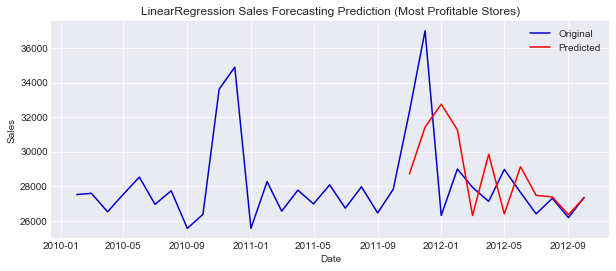

In [45]:
# We'll apply the regressive model function for three different types of models.
# We'll start with a Linear Regression.
regressive_model(train, test, LinearRegression(),'LinearRegression', most_df)

RMSE: 3720.2946199214884
MAE: 2610.194750202088
R2 Score: -0.5463022347143842


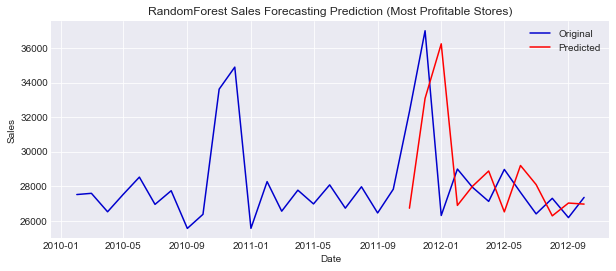

In [46]:
# Now for Random Forest. 
regressive_model(train, test, 
                 RandomForestRegressor(n_estimators=100,
                                       max_depth=20),        
                                       'RandomForest', most_df)

RMSE: 3756.7188077910505
MAE: 2407.255178025014
R2 Score: -0.5767291379329824


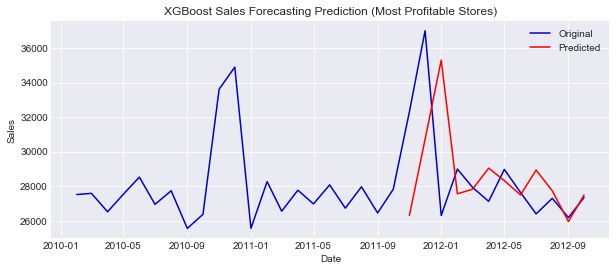

In [47]:
# And now XGBoost.
regressive_model(train, test, XGBRegressor(n_estimators=100,
                                            learning_rate=0.1), 
                                            'XGBoost', most_df)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/200
8/8 [==============================] - 0s 54ms/sample - loss: 0.8249
Epoch 2/200
8/8 [==============================] - 0s 1ms/sample - loss: 0.8130
Epoch 3/200
8/8 [==============================] - 0s 1ms/sample - loss: 0.8030
Epoch 4/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.7936
Epoch 5/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.7846
Epoch 6/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.7761
Epoch 7/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.7680
Epoch 8/200
8/8 [==============================] - 0s 1ms/sample - loss: 0.7602
Epoch 9/200
8/8 [==============================] - 0s 1ms/sample - loss: 0.7527
Epoch 10/200
8/8 [==============================] - 0s 2ms/sample -

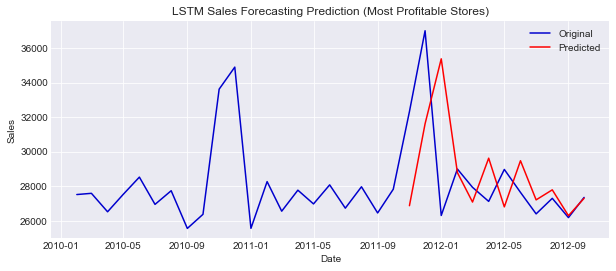

In [48]:
# For an LSTM model, we'll have to modify things a bit.
def lstm_model(train_data, test_data, original_df):

    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # To build the model, we must go through these steps.
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], 
                                         X_train.shape[2]), 
                                         stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test, batch_size=1)
    unscaled = undo_scaling(predictions, X_test, scaler_object, 
                            lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    get_scores(unscaled_df, original_df, 'LSTM')
    plot_results(unscaled_df, original_df, 'LSTM')

# We'll apply the LSTM model to most_df now.
lstm_model(train, test, most_df)

In [49]:
# Before we do the same for least profitable stores, we'll modify the plot_results
# function so that the title is accurate. We'll also change the line colors to
# make differentiation more convenient.
def plot_results(results, original_df, model_name):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(original_df.date, original_df.average_weekly_sales, data=original_df, ax=ax,
                 label='Original', color='maroon')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax,
                 label='Predicted', color='orange')
    ax.set(xlabel="Date",
           ylabel="Sales",
           title=f"{model_name} Sales Forecasting Prediction (Least Profitable Stores)")
    ax.legend()
    sns.despine()
    plt.savefig(f'Images/{model_name} (Least Profitable Stores).png')
    plt.show()

In [50]:
# We will now make new train and test data for the least profitable stores.
train2, test2 = tts(least_model_df)

RMSE: 248.76345434739753
MAE: 166.32243872387735
R2 Score: -3.984421981506258


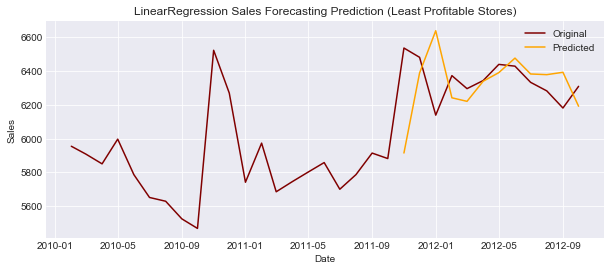

In [51]:
# Linear Regression.
regressive_model(train2, test2, LinearRegression(),'LinearRegression', least_df)

RMSE: 225.0476823844026
MAE: 142.17295986855189
R2 Score: -3.07934780225279


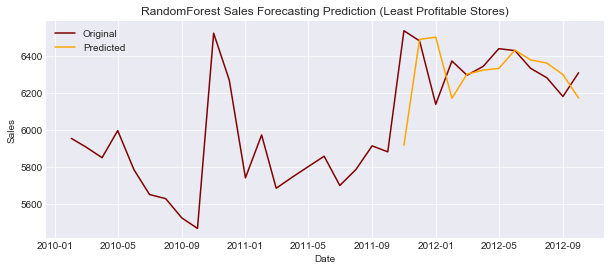

In [52]:
# Random Forest.
regressive_model(train2, test2, 
                 RandomForestRegressor(n_estimators=100,
                                       max_depth=20),        
                                       'RandomForest', least_df)

RMSE: 261.93622585152906
MAE: 217.05612186277367
R2 Score: -4.526278608760955


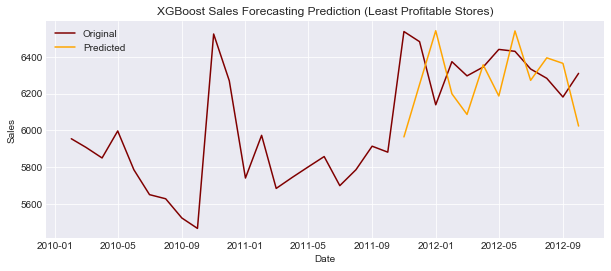

In [53]:
# XGBoost.
regressive_model(train2, test2, XGBRegressor(n_estimators=100,
                                            learning_rate=0.1), 
                                            'XGBoost', least_df)

Epoch 1/200
8/8 [==============================] - 1s 66ms/sample - loss: 0.5573
Epoch 2/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.5459
Epoch 3/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.5271
Epoch 4/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.5087
Epoch 5/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.4919
Epoch 6/200
8/8 [==============================] - 0s 1ms/sample - loss: 0.4768
Epoch 7/200
8/8 [==============================] - 0s 3ms/sample - loss: 0.4631
Epoch 8/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.4508
Epoch 9/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.4395
Epoch 10/200
8/8 [==============================] - 0s 2ms/sample - loss: 0.4293
Epoch 11/200
8/8 [==============================] - 0s 1ms/sample - loss: 0.4201
Epoch 12/200
8/8 [==============================] - 0s 1ms/sample - loss: 0.4117
Epoch 13/200
8/8 [==================

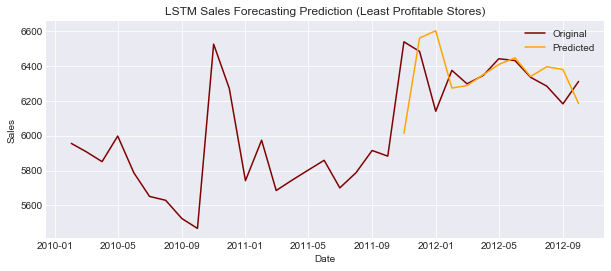

In [54]:
# We can now apply the LSTM model to least_df.
lstm_model(train2, test2, least_df)